In [7]:
#Import libraries 
import hvplot.pandas as hvplot
import pandas as pd 
import csv

#Define the file path
file = "./Data/time_series_covid19_confirmed_US.csv"
#Read the csv
covid_df = pd.read_csv(file)
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [11]:
#Cleaning the data
clean_df = covid_df.loc[covid_df["Long_"] != 0.0]
clean_df = clean_df.dropna()

clean_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,19732,19759,19759,19759,19759,19759,19759,19759,19790,19790
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,69641,69767,69767,69767,69767,69767,69767,69767,69860,69860
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,7451,7474,7474,7474,7474,7474,7474,7474,7485,7485
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,8067,8087,8087,8087,8087,8087,8087,8087,8091,8091
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,18616,18673,18673,18673,18673,18673,18673,18673,18704,18704


In [9]:
#Example
minnesota_df = clean_df.loc[covid_df["Province_State"] == "Minnesota"]
minnesota_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
1369,84027001,US,USA,840,27001.0,Aitkin,Minnesota,US,46.609620,-93.411683,...,3679,3679,3696,3696,3696,3696,3696,3696,3696,3702
1370,84027003,US,USA,840,27003.0,Anoka,Minnesota,US,45.274760,-93.246046,...,118906,118906,119208,119208,119208,119208,119208,119208,119208,119415
1371,84027005,US,USA,840,27005.0,Becker,Minnesota,US,46.934794,-95.671581,...,10456,10456,10489,10489,10489,10489,10489,10489,10489,10509
1372,84027007,US,USA,840,27007.0,Beltrami,Minnesota,US,47.973735,-94.937321,...,14326,14326,14371,14371,14371,14371,14371,14371,14371,14406
1373,84027009,US,USA,840,27009.0,Benton,Minnesota,US,45.698050,-93.995141,...,16981,16981,17025,17025,17025,17025,17025,17025,17025,17064


In [10]:
minnesota_map = minnesota_df.hvplot.points(
    "Long_",
    "Lat",
    geo = True,
    color="Admin2"
    
)
minnesota_map

:Points   [Long_,Lat]   (Admin2)

<Axes: xlabel='Admin2'>

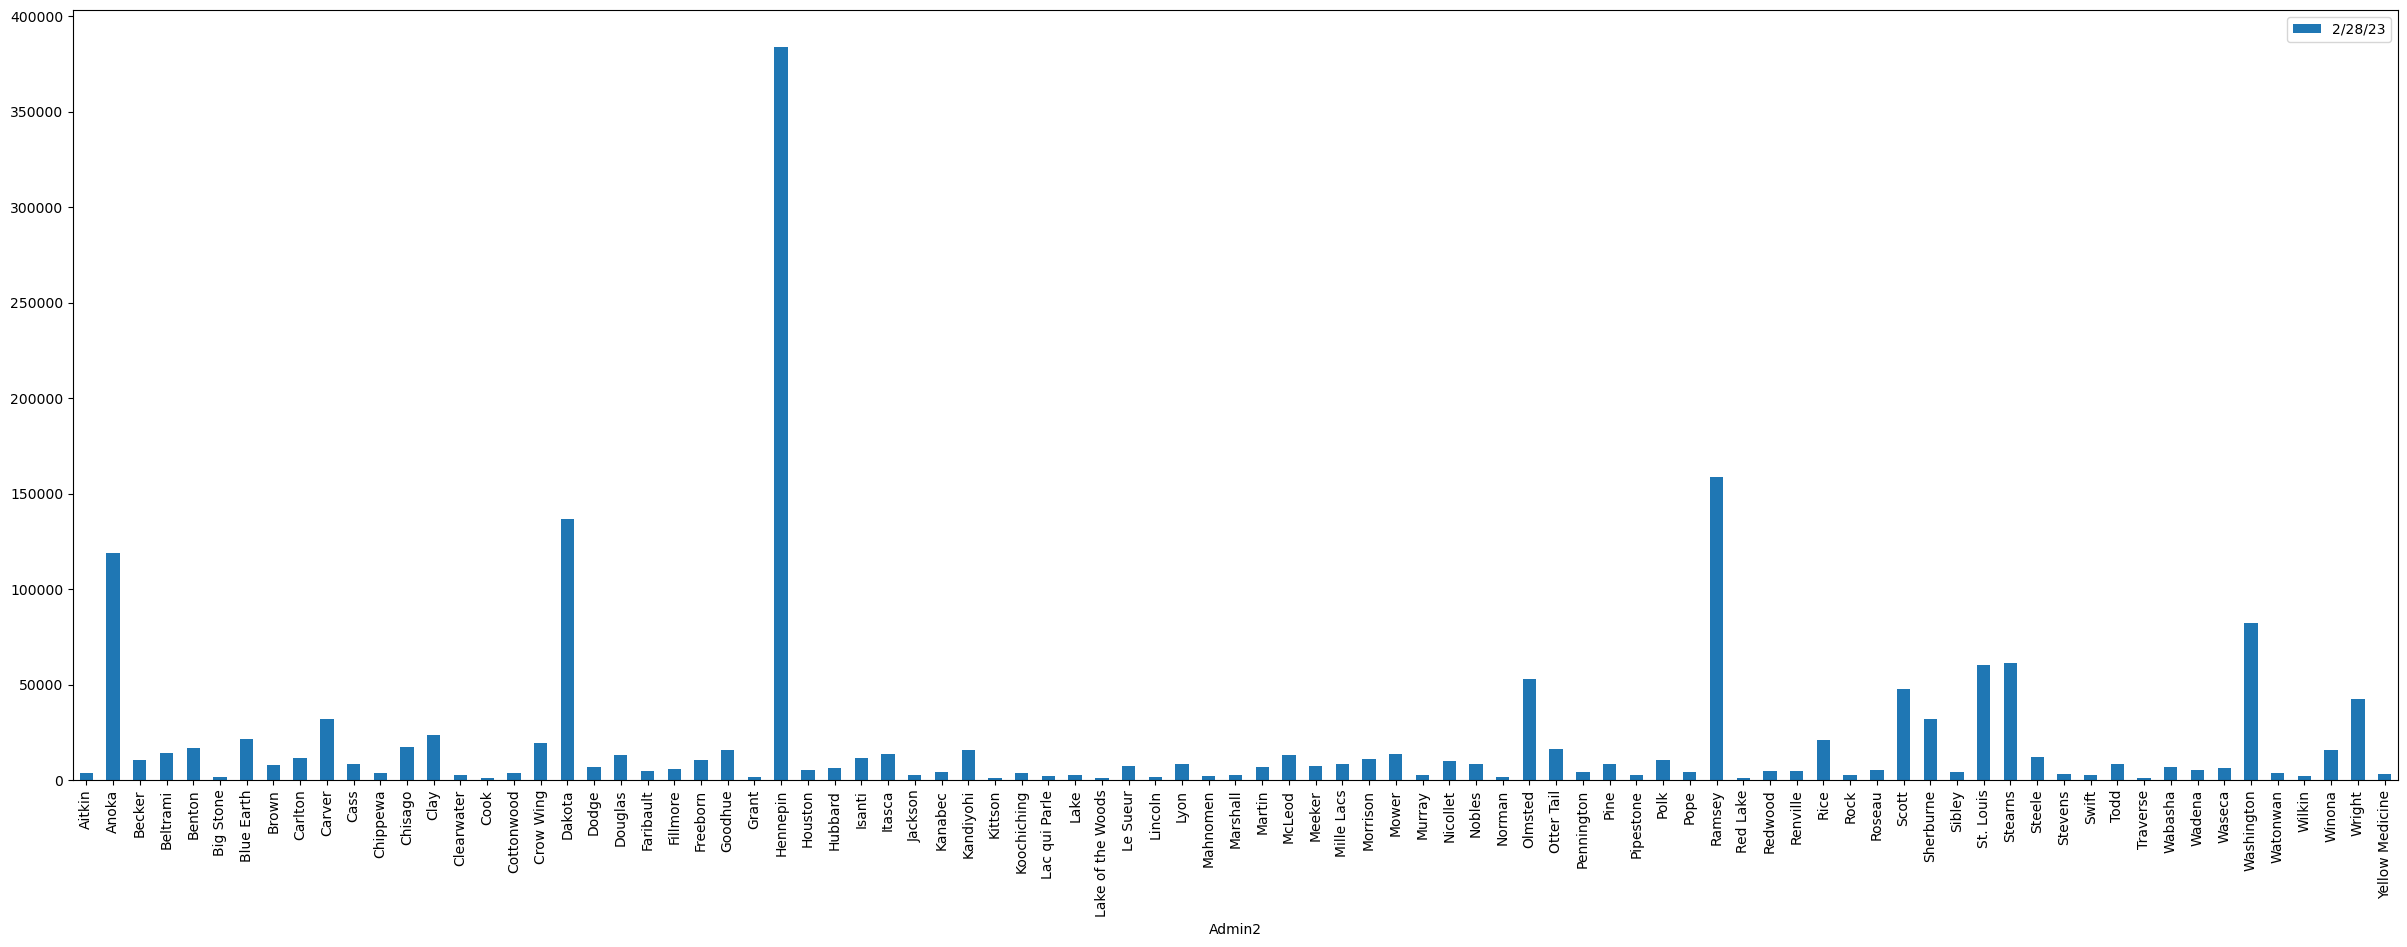

In [21]:
minnesota_df.plot("Admin2","2/28/23",kind="bar",figsize=(30,10))


In [ ]:
#Viktor

In [ ]:
#Viktor

In [ ]:
#Samantha

In [ ]:
#Samantha

In [ ]:
#Nicholas

In [ ]:
#Nicholas

In [ ]:
#Mysee

In [ ]:
#Mysee

In [ ]:
#Micah

In [ ]:
#Micah